Synthetic Data Sample:
   age  length_of_stay  num_medications  num_lab_tests  comorbidity_index  \
0   72               6               11             13           5.862991   
1   62               5                7             20           2.848157   
2   74               4                7              8           0.837215   
3   87               3               10             13           2.190386   
4   61               5               10             17           3.473038   

  insurance_type  previous_readmissions  readmitted_30days  
0       Medicaid                      1                  1  
1       Medicare                      0                  0  
2       Medicare                      0                  0  
3       Medicaid                      1                  0  
4       Medicare                      1                  0  

Confusion Matrix:
[[148  12]
 [  8  32]]

Precision: 0.73
Recall: 0.80

Top Features Influencing Readmission:


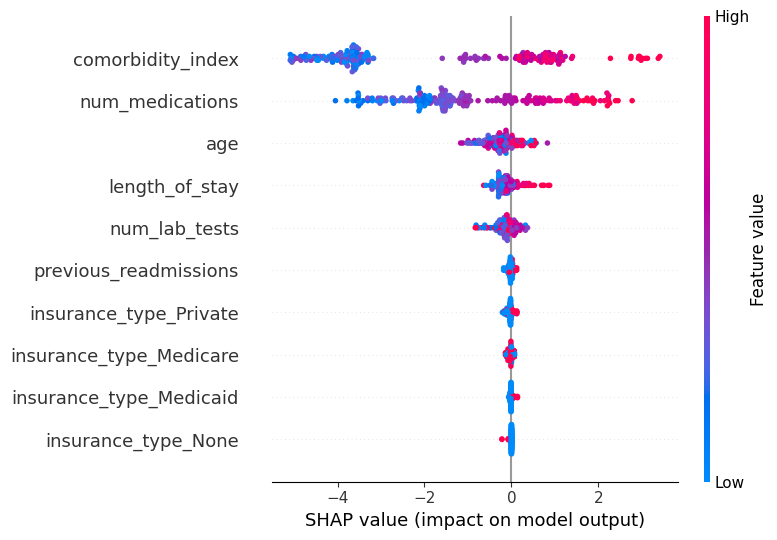


Sample Prediction:
{'readmission_probability': 0.9136857986450195, 'interpretation': 'High risk'}


In [3]:
# ======================
# 1. Imports & Setup
# ======================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from xgboost import XGBClassifier
import shap  # For model interpretability
import pickle
import warnings
warnings.filterwarnings('ignore')

# ======================
# 2. Synthetic Data Generation
# (Replace with actual EHR connection)
# ======================
def generate_synthetic_ehr_data(n_patients=1000):
    np.random.seed(42)

    data = {
        'age': np.random.normal(65, 15, n_patients).astype(int),
        'length_of_stay': np.random.lognormal(1.5, 0.3, n_patients).astype(int),
        'num_medications': np.random.poisson(8, n_patients),
        'num_lab_tests': np.random.poisson(15, n_patients),
        'comorbidity_index': np.random.beta(2,5, n_patients)*10,
        'insurance_type': np.random.choice(['Medicare','Private','Medicaid','None'],
                                         n_patients, p=[0.5,0.3,0.15,0.05]),
        'previous_readmissions': np.random.poisson(0.3, n_patients),
        'readmitted_30days': np.random.binomial(1, 0.2, n_patients)  # Target
    }

    # Create correlations with target
    data['comorbidity_index'] += data['readmitted_30days']*3
    data['num_medications'] += data['readmitted_30days']*5
    return pd.DataFrame(data)

df = generate_synthetic_ehr_data()
print("Synthetic Data Sample:")
print(df.head())

# ======================
# 3. Data Preprocessing Pipeline
# ======================
# Define features
numeric_features = ['age', 'length_of_stay', 'num_medications',
                   'num_lab_tests', 'comorbidity_index', 'previous_readmissions']
categorical_features = ['insurance_type']

# Create transformers
numeric_transformer = RobustScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Feature engineering
X = df.drop('readmitted_30days', axis=1)
y = df['readmitted_30days']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Preprocess data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# ======================
# 4. Model Training with Cross-Validation
# ======================
model = XGBClassifier(
    scale_pos_weight=(len(y_train) - sum(y_train))/sum(y_train),  # Handle class imbalance
    eval_metric='logloss',
    early_stopping_rounds=10,
    subsample=0.8,
    colsample_bytree=0.8
)

# Stratified K-Fold CV
cv = StratifiedKFold(n_splits=5)
for train_idx, val_idx in cv.split(X_train_processed, y_train):
    X_tr, X_val = X_train_processed[train_idx], X_train_processed[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=0
    )

# ======================
# 5. Evaluation
# ======================
y_pred = model.predict(X_test_processed)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"\nPrecision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# ======================
# 6. Model Interpretability (SHAP)
# ======================
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_processed)

print("\nTop Features Influencing Readmission:")
feature_names = numeric_features + \
    list(preprocessor.named_transformers_['cat'].get_feature_names_out())
shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names)

# ======================
# 7. Deployment Preparation
# ======================
# Save artifacts
with open('readmission_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

# HIPAA-compliant prediction function
def predict_readmission_risk(patient_data):
    """Secure prediction function for deployment"""
    processed_data = preprocessor.transform(patient_data)
    proba = model.predict_proba(processed_data)[:, 1]
    return {'readmission_probability': float(proba[0]),
            'interpretation': "High risk" if proba > 0.5 else "Low risk"}

# Example usage
sample_patient = pd.DataFrame([{
    'age': 72,
    'length_of_stay': 7,
    'num_medications': 12,
    'num_lab_tests': 18,
    'comorbidity_index': 6.2,
    'previous_readmissions': 1,
    'insurance_type': 'Medicare'
}])

print("\nSample Prediction:")
print(predict_readmission_risk(sample_patient))

In [ ]:
# Ensure your notebook is saved with the correct name
from google.colab import drive
drive.mount('/content/drive')  # Only if using Google Drive

# Save a copy (replace with your actual notebook name)
!cp "/content/drive/MyDrive/Colab Notebooks/Hospital Readmission Prediction.ipynb" "/content/Hospital Readmission Prediction.ipynb"